>📘 Learning Objectives
>
> 1. Load ERDDAP data with xarray
> 2. Use some `xarray` functions on data cubes

## Summary

We can open ERDDAP datasets with `xarray`. Make sure that the url points to the dataset without any subsetting of specification. Under the hood, ERDDAP uses OPeNDAP and `xarray` will load the metadata (lazily). After loading, you can subset the data as needed.

We will use the [Multi-scale Ultra-high Resolution (MUR) SST Analysis fv04.1, Global, 0.01°, 2002-present, Daily](https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41.html) data from NASA JPL. This is a high-resolution dataset of over 150 terabytes.

#### For those not working in the JupyterHub

[![image](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nmfs-opensci/NOAAHackDays/blob/main/topics-2025/2025-02-28-ERDDAP-Py/erddap_xarray.ipynb) and then create a code cell and run `pip install xarray`.

## Load the data set (lazily)

In [11]:
import xarray as xr
url = "https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41"
ds = xr.open_dataset(url)
print(f"Size in TB: {ds.nbytes / 1e12:.2f} TB")
ds.sizes

Size in TB: 150.77 TB


Frozen({'time': 8310, 'latitude': 17999, 'longitude': 36000})

In [2]:
ds

<xarray.Dataset> Size: 151TB
Dimensions:           (time: 8310, latitude: 17999, longitude: 36000)
Coordinates:
  * time              (time) datetime64[ns] 66kB 2002-06-01T09:00:00 ... 2025...
  * latitude          (latitude) float32 72kB -89.99 -89.98 ... 89.98 89.99
  * longitude         (longitude) float32 144kB -180.0 -180.0 ... 180.0 180.0
Data variables:
    analysed_sst      (time, latitude, longitude) float64 43TB ...
    analysis_error    (time, latitude, longitude) float64 43TB ...
    mask              (time, latitude, longitude) float32 22TB ...
    sea_ice_fraction  (time, latitude, longitude) float64 43TB ...
Attributes: (12/51)
    _NCProperties:              version=2,netcdf=4.7.4,hdf5=1.8.12
    acknowledgement:            Please acknowledge the use of these data with...
    cdm_data_type:              Grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    Conventions:                CF-1.6, COARDS, ACDD-1.3
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    This is a merged, multi-sensor L4 Foundation ...
    testOutOfDate:              now-3days
    time_coverage_end:          2025-03-04T09:00:00Z
    time_coverage_start:        2002-06-01T09:00:00Z
    title:                      Multi-scale Ultra-high Resolution (MUR) SST A...
    Westernmost_Easting:        -179.99

## Subset this data set

First we will select the SST variable, subset to a 2 degree box and 1 year of data. This will create a much smaller data set or 120 Mb.

In [19]:
dc = ds['analysed_sst'].sel(
                        latitude=slice(33.5, 35.5), 
                        longitude=slice(-75.5, -73.5), 
                        time=slice('2003-01-01', '2003-12-31'))
print(f"Size in GB: {dc.nbytes / 1e9:.2f} GB")
dc.sizes

Size in GB: 0.12 GB


Frozen({'time': 365, 'latitude': 201, 'longitude': 201})

In [20]:
%%time
# Load the data into memory so the next steps are fast
dc.load();

CPU times: user 1.15 s, sys: 275 ms, total: 1.43 s
Wall time: 45.9 s


## Plot one day

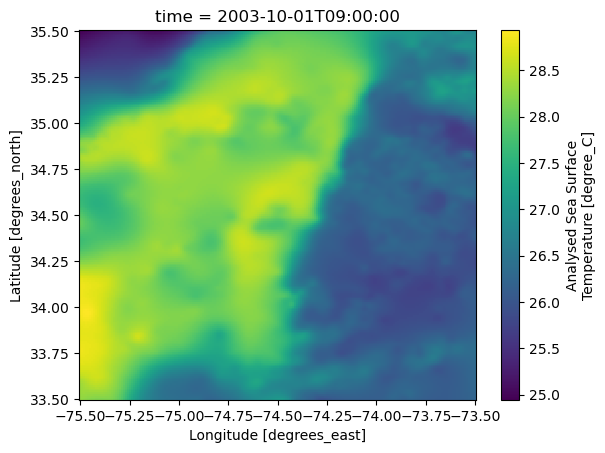

In [14]:
dc.sel(time="2003-10-01").plot();

## Compute the mean SST over the whole data set

Computing the mean for an data array returns a data array and here `.item()` is used to just return the value.

In [23]:
dc.mean().item()

24.8006164888092

### We can plot the spatial mean raster

We do this by taking the mean over the time dimension.

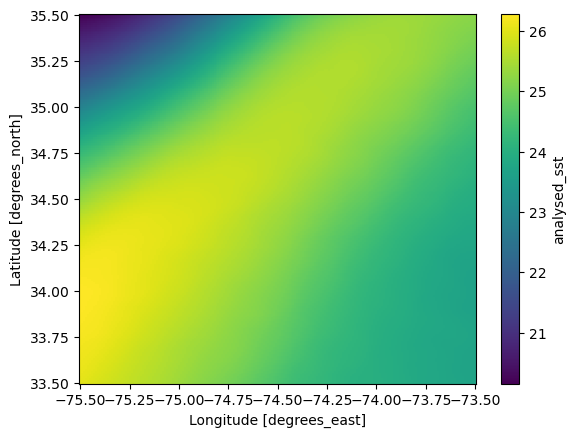

In [24]:
dc.mean(dim=['time']).plot();

### We can plot the daily means

We do this by taking the mean over the space dimensions.

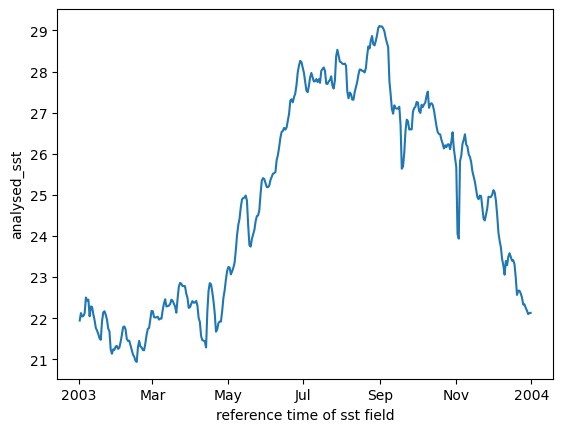

In [25]:
dc.mean(dim=['latitude', 'longitude']).plot();

## Resample to create monthly means

The `resample` function takes a long time if you don't have the data loaded in memory already. So you will want to run something like `dc.load()` (or `dc.mean()` or `dc.compute()`) before running the resample code.

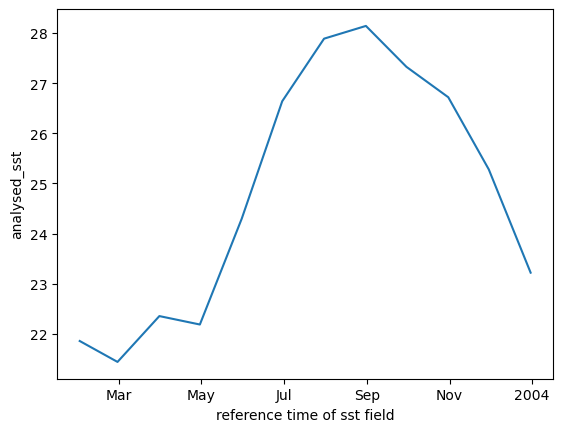

In [26]:
dc_monthly = dc.resample(time='ME').mean()
dc_monthly.mean(dim=['latitude', 'longitude']).plot();

## Chunking to do larger than memory computations

If we load in all the days for our 2 degree square, it is a bit larger than the memory on the small virtual machines (> 2 Gb) of the large data set is 18 Gb. If we try to take the mean of one day it would use up all the memory if we have less than that. We can use `dask` and chunking to do the calculation in smaller chunks so we don't run out of memory.

In [27]:
dc_all = ds['analysed_sst'].sel(
                        latitude=slice(33.5, 35.5), 
                        longitude=slice(-75.5, -73.5))

In [32]:
print(f"Size in GB: {dc_all.nbytes / 1e9:.2f} GB")
dc_all.sizes

Size in GB: 2.69 GB


Frozen({'time': 8310, 'latitude': 201, 'longitude': 201})

In [2]:
import dask
ds_chunk = ds['analysed_sst'].isel(time=1)  
ds_chunk = ds_chunk.chunk({'latitude': 10000, 'longitude': 10000})
ds_chunk

<xarray.DataArray 'analysed_sst' (latitude: 17999, longitude: 36000)> Size: 5GB
dask.array<xarray-<this-array>, shape=(17999, 36000), dtype=float64, chunksize=(10000, 10000), chunktype=numpy.ndarray>
Coordinates:
    time       datetime64[ns] 8B 2002-06-02T09:00:00
  * latitude   (latitude) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * longitude  (longitude) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
Attributes:
    colorBarMaximum:  32.0
    colorBarMinimum:  0.0
    comment:          Interim near-real-time (nrt) version using Multi-Resolu...
    ioos_category:    Temperature
    long_name:        Analysed Sea Surface Temperature
    source:           MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRRMTB_G-NAVO,...
    standard_name:    sea_surface_foundation_temperature
    units:            degree_C
    valid_max:        57.767
    valid_min:        -7.767000000000003

In [ ]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    mean_chunk = ds_chunk.mean(dim=['latitude', 'longitude']).compute()

[###                                     ] | 9% Completed | 10m 21sss

In [8]:
dc_monthly = dc.resample(time='ME').mean()
dc_one_month = dc_monthly.sel(time="2010-01")
dc_monthly

<xarray.DataArray 'analysed_sst' (time: 274, latitude: 201, longitude: 201)> Size: 89MB
dask.array<transpose, shape=(274, 201, 201), dtype=float64, chunksize=(32, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 804B 33.5 33.51 33.52 ... 35.48 35.49 35.5
  * longitude  (longitude) float32 804B -75.5 -75.49 -75.48 ... -73.51 -73.5
  * time       (time) datetime64[ns] 2kB 2002-06-30 2002-07-31 ... 2025-03-31
Attributes:
    colorBarMaximum:  32.0
    colorBarMinimum:  0.0
    comment:          Interim near-real-time (nrt) version using Multi-Resolu...
    ioos_category:    Temperature
    long_name:        Analysed Sea Surface Temperature
    source:           MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRRMTB_G-NAVO,...
    standard_name:    sea_surface_foundation_temperature
    units:            degree_C
    valid_max:        57.767
    valid_min:        -7.767000000000003

In [ ]:
%%time
dc_one_month.mean(dim=['latitude', 'longitude']).compute()

In [ ]:
dc_one_month = dc_monthly.sel(time="2010-01")
dc_mean = dc_one_month.mean(dim=['latitude', 'longitude']).compute()
dc_mean



In [4]:
dc_monthly

<xarray.DataArray 'analysed_sst' (time: 273, latitude: 201, longitude: 201)> Size: 88MB
dask.array<transpose, shape=(273, 201, 201), dtype=float64, chunksize=(32, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 804B 33.5 33.51 33.52 ... 35.48 35.49 35.5
  * longitude  (longitude) float32 804B -75.5 -75.49 -75.48 ... -73.51 -73.5
  * time       (time) datetime64[ns] 2kB 2002-06-01 2002-07-01 ... 2025-02-01
Attributes:
    colorBarMaximum:  32.0
    colorBarMinimum:  0.0
    comment:          Interim near-real-time (nrt) version using Multi-Resolu...
    ioos_category:    Temperature
    long_name:        Analysed Sea Surface Temperature
    source:           MODIS_T-JPL, MODIS_A-JPL, AMSR2-REMSS, AVHRRMTB_G-NAVO,...
    standard_name:    sea_surface_foundation_temperature
    units:            degree_C
    valid_max:        57.767
    valid_min:        -7.767000000000003

In [ ]:
%%time
# Compute mean over latitude/longitude before converting
dc_mean = dc_monthly.mean(dim=['latitude', 'longitude']).compute()

In [ ]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    dc_mean = dc_monthly.mean(dim=['latitude', 'longitude']).compute()

[                                        ] | 1% Completed | 171.49 ss

In [ ]:

# Now convert and plot
dc_mean.to_pandas().plot()
plt.show()


In [ ]:
dc_monthly.mean(dim=['latitude', 'longitude']).to_pandas().plot();

In [ ]:
# Compute explicitly when needed
dc_monthly = dc_monthly.compute()  # If you need to finalize the result


In [1]:
from erddapy import ERDDAP
e = ERDDAP(
    server="https://coastwatch.pfeg.noaa.gov/erddap",
    protocol="griddap",
)
e.dataset_id = "jplMURSST41"
ds = e.to_xarray()

HTTPError: Error {
    code=413;
    message="Payload Too Large: Your query produced too much data.  Try to request less data. [memory]  128301168 MB is more than the .nc 2 GB limit.";
}


<xarray.Dataset> Size: 151TB
Dimensions:           (time: 8307, latitude: 17999, longitude: 36000)
Coordinates:
  * time              (time) datetime64[ns] 66kB 2002-06-01T09:00:00 ... 2025...
  * latitude          (latitude) float32 72kB -89.99 -89.98 ... 89.98 89.99
  * longitude         (longitude) float32 144kB -180.0 -180.0 ... 180.0 180.0
Data variables:
    analysed_sst      (time, latitude, longitude) float64 43TB ...
    analysis_error    (time, latitude, longitude) float64 43TB ...
    mask              (time, latitude, longitude) float32 22TB ...
    sea_ice_fraction  (time, latitude, longitude) float64 43TB ...
Attributes: (12/51)
    _NCProperties:              version=2,netcdf=4.7.4,hdf5=1.8.12
    acknowledgement:            Please acknowledge the use of these data with...
    cdm_data_type:              Grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    Conventions:                CF-1.6, COARDS, ACDD-1.3
    creator_email:              g

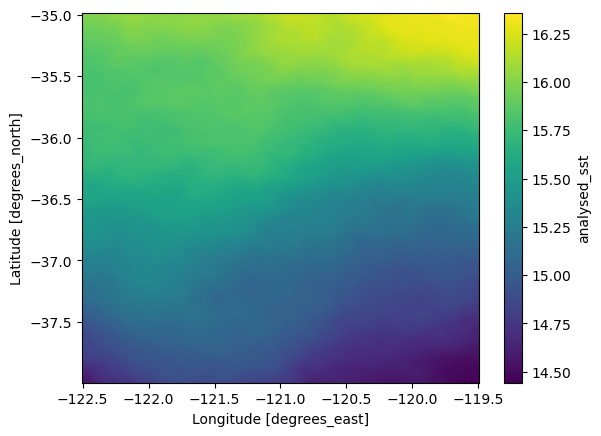

In [1]:
import xarray as xr

url = "https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41"
ds = xr.open_dataset(url)
print(ds)
dc = ds['analysed_sst'].sel(
                        latitude=slice(-37.99, -34.99), 
                        longitude=slice(-122.5, -119.5), 
                        time=slice('2002-01-01', '2002-12-31'))
print(dc)

mean = dc.mean()  #738MB/ 1899MB (before running this it was ~400MB memo used)
print(mean)

dc.mean(dim=['latitude', 'longitude'])
dc.mean(dim=['time']).plot()

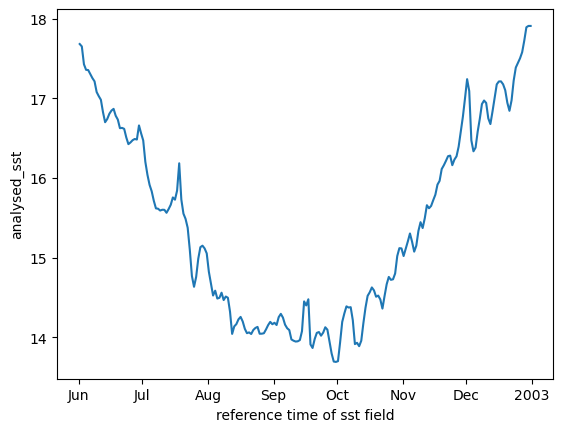

In [3]:
dc.mean(dim=['latitude', 'longitude']).plot()

In [3]:
import xarray as xr

url = "https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41"
ds = xr.open_dataset(url)
dc = ds['analysed_sst'].sel(
                        latitude=slice(-37.99, -34.99), 
                        longitude=slice(-122.5, -119.5), 
                        time=slice('2003-01-01', '2003-12-31'))

In [11]:
len(dc.time)

365

In [2]:
import dask
dc = dc.chunk({'time': -1, 'latitude': 10, 'longitude': 10})  # Ensure it remains chunked

In [9]:
from dask.distributed import Client

client = Client(dashboard_address=":8899")  # Change to any available port
client

/srv/conda/envs/notebook/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8899 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45781 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45781/status,
Dashboard: http://127.0.0.1:45781/status,Workers: 4
Total threads: 4,Total memory: 1.85 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36323,Workers: 4
Dashboard: http://127.0.0.1:45781/status,Total threads: 4
Started: Just now,Total memory: 1.85 GiB
Comm: tcp://127.0.0.1:46417,Total threads: 1
Dashboard: http://127.0.0.1:33791/status,Memory: 474.75 MiB
Nanny: tcp://127.0.0.1:35759,


In [13]:
%%time
dc_mean = dc.mean(dim=['latitude', 'longitude']).compute()

CPU times: user 8.35 s, sys: 999 ms, total: 9.35 s
Wall time: 1min 13s


In [ ]:
from dask.diagnostics import ProgressBar

with ProgressBar():
    dc_mean = dc.mean(dim=['latitude', 'longitude']).compute()


[##############                          ] | 36% Completed | 75.32 ss

In [14]:
# import dask for parallel work
from dask.distributed import Client, LocalCluster

# Set up a new cluster with default 4 workers and 1 thread per worker
cluster = LocalCluster(n_workers=4, processes=False, threads_per_worker=1)
cluster

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45637 instead
  warnings.warn(


LocalCluster(2eda92dd, 'inproc://192.168.35.75/21701/24', workers=4, threads=4, memory=1.85 GiB)

2025-03-05 01:39:21,257 - distributed.worker.memory - WARNING - Worker is at 175% memory usage. Pausing worker.  Process memory: 833.78 MiB -- Worker memory limit: 474.75 MiB
2025-03-05 01:39:21,375 - distributed.worker.memory - WARNING - Worker is at 175% memory usage. Pausing worker.  Process memory: 833.78 MiB -- Worker memory limit: 474.75 MiB
2025-03-05 01:39:21,489 - distributed.worker.memory - WARNING - Worker is at 175% memory usage. Pausing worker.  Process memory: 833.78 MiB -- Worker memory limit: 474.75 MiB
2025-03-05 01:39:21,600 - distributed.worker.memory - WARNING - Worker is at 175% memory usage. Pausing worker.  Process memory: 833.78 MiB -- Worker memory limit: 474.75 MiB


In [4]:
# define our functions
def inc(x):
    return float(dc.isel(time=x).mean(dim=['latitude', 'longitude']).compute().values)

In [5]:
inc(1)

17.975603646758866

In [ ]:
%%time
# Set up a client for work
client = cluster.get_client()

results = []
for x in range(len(dc.time)):
    result = client.submit(inc, x)
    results.append(result.result())

client.close()

/srv/conda/envs/notebook/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 252.31 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [8]:
%%time
# Set up a client for work
client = cluster.get_client()
futures = [client.submit(inc, x) for x in range(20)]
results = client.gather(futures)  # Collects all results at once
print(results)
client.close()

[17.802982847871437, 17.975603646758866, 18.14861190273838, 18.26376102912771, 18.413832540479685, 18.494760223397094, 18.680023090252867, 18.92435910199667, 19.180562455160533, 19.325590412909353, 19.2058658624077, 19.372866546726858, 19.700343616516374, 19.579123144336155, 19.270368097482365, 19.37021501970177, 19.73552030330791, 20.082728181808147, 20.367333406916035, 20.46920739285439]
CPU times: user 1.4 s, sys: 90.2 ms, total: 1.49 s
Wall time: 12.9 s


In [12]:
365/20

18.25

In [ ]:
%%time
# Set up a client for work
client = cluster.get_client()

dc_mean = dc.mean(dim=['latitude', 'longitude']).compute()

syntax error, unexpected $end, expecting ';'
context: Error { code=503; message="Service Unavailable: There was a (temporary?) problem. Wait a minute, then try again. (In a browser, click the Reload button.)";}^


In [ ]:
client.close()
cluster.close()

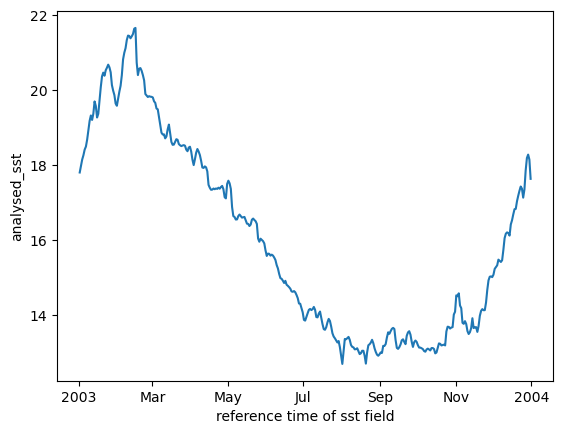

In [7]:
dc_mean.plot()

In [14]:
%%time
dc.isel(time=slice(0,1)).mean(dim=['latitude', 'longitude'])

CPU times: user 8.51 ms, sys: 5.2 ms, total: 13.7 ms
Wall time: 612 ms


<xarray.DataArray 'analysed_sst' (time: 1)> Size: 8B
array([17.68239177])
Coordinates:
  * time     (time) datetime64[ns] 8B 2002-06-01T09:00:00

In [17]:
%%time
dc.isel(time=slice(0,101)).mean(dim=['latitude', 'longitude'])

CPU times: user 704 ms, sys: 200 ms, total: 904 ms
Wall time: 21.6 s


<xarray.DataArray 'analysed_sst' (time: 101)> Size: 808B
array([17.68239177, 17.65205698, 17.42795117, 17.35859971, 17.35557652,
       17.30397063, 17.25439463, 17.21387798, 17.07969612, 17.02785009,
       16.98250892, 16.82617434, 16.70076668, 16.74087835, 16.80656006,
       16.84701081, 16.86830618, 16.78209559, 16.73386654, 16.62595825,
       16.62941572, 16.61769446, 16.50935697, 16.42564089, 16.44723482,
       16.4752216 , 16.49036981, 16.4832666 , 16.66048885, 16.56099804,
       16.47185112, 16.20334063, 16.03982808, 15.91436474, 15.83389242,
       15.71467536, 15.61934613, 15.61490924, 15.59205686, 15.60181528,
       15.60111937, 15.56382465, 15.610601  , 15.66422289, 15.75650469,
       15.72821324, 15.8429399 , 16.18521092, 15.73049302, 15.55300795,
       15.48723956, 15.37579203, 15.10021107, 14.77015102, 14.63457105,
       14.75812838, 14.98714799, 15.13222896, 15.15081254, 15.11646546,
       15.05412748, 14.8238566 , 14.6706374 , 14.52517478, 14.58587587,
       14.48713001, 14.49637659, 14.56050951, 14.46826665, 14.51247324,
       14.49718522, 14.32206422, 14.04310472, 14.1374156 , 14.16621883,
       14.22622649, 14.25667584, 14.19922014, 14.10696748, 14.05251879,
       14.06212404, 14.04185816, 14.09248185, 14.11806067, 14.13131394,
       14.04536419, 14.04601728, 14.0515624 , 14.09927964, 14.15368965,
       14.19440194, 14.16476757, 14.18299891, 14.15486561, 14.25380548,
       14.29502749, 14.24799966, 14.15911841, 14.11450218, 14.09129411,
       13.97390767])
Coordinates:
  * time     (time) datetime64[ns] 808B 2002-06-01T09:00:00 ... 2002-09-09T09...

In [2]:
import dask
dc = dc.chunk({'time': -1, 'latitude': 50, 'longitude': 50})  # Ensure it remains chunked


In [ ]:
%%time
dc.mean(dim=['latitude', 'longitude']).plot()